# Robustness of model (fraction of isolates per season)
We will evaluate the performance of the proposed RF model over 14 test seasons from 2014NH to 2020SH, where we will condiser a subset of training data containing all the HI titers of only 20-80% randomly selected virus isolates in each historical season from 2003NH up to the test season.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import utilities   # self defined functions
import model_utilities   # self defined models
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder

# (for reproduciblility) fix the randomly generated numbers
SEED = 100
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = "AZAE970101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',
                 'serumPassCat'
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'optimized_RF'   # the type of model to be used

perc_isolates_train_all = [100, 80, 60, 40, 20]   # percentage of isolates per season in training dataset

n_run_start = 0   # No. of simulation runs as well as
n_run_end   = 50   # seed for the random selection of HI titers

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig4_robustness/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
test_fn = path_result + "SuppFig4b_robustness_rndIsolatesTrainSeason.csv"   # to save performance scores for test dataset
fig_fn  = path_result + "SuppFig4b_robustness_rndIsolatesTrainSeason.svg"   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [ ]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Performance of the model
- For each run, for 50 runs
    - For fraction of isolates from 100% to 20%
        - For each test season from 2014NH to 2020SH
            - Split the data into training and test datasets
            - Prepare encoded inputs (genetic difference and metadata features)
            - Train and evaluate the model
            - Compute predictive performance
            - Save the predictions
        - Compute average predictive performance

In [ ]:
'''
Number of simulation (Monte-carlo) runs and
Random selection of isolates per season in training dataset depends on this number used as SEED
'''
for run in range(n_run_start, n_run_end):
    
    '''
    Percentage of isolates in training dataset
    '''
    for perc_isolates_train in perc_isolates_train_all:
        
        # for 100% isolates, only run once
        if perc_isolates_train == 100 and run > 0:
            continue
        
        '''
        Test Seasons
        '''
        # to collect actuals and predictions for micro-averaged scores over all test seasons
        actual_all  = {}
        predict_all = {}

        # loop through test seasons
        for test_season in Test_Seasons:
            print("run: ", run,
                  ",   isolates per season for training: ", perc_isolates_train,
                  "%,   test season: ", test_season)

            '''
            Train Test Split
                - based on seasonal framework
                - Train: past virus isolates paired with past sera
                - Test: circulating virus isolates paired with past sera
            '''
            ind_train, ind_test = utilities.rndIsolatesTrainSeason_seasonal_trainTestSplit(data.copy(),
                                                                                          test_season,
                                                                                          isolates_train=perc_isolates_train,
                                                                                          random_state=run)

            # training dataset
            data_train = data.iloc[ind_train].copy()
            data_train.reset_index(drop=True, inplace=True)

            # test dataset
            data_test = data.iloc[ind_test].copy()
            data_test.reset_index(drop=True, inplace=True)


            '''
            Input features (genetic difference)
            '''
            # training dataset
            X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                                   index=data_train.index,
                                   columns=HA1_features)
            X_train.fillna(0, inplace=True)   # replace nan with 0

            # test dataset
            X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                                   index=data_test.index,
                                   columns=HA1_features)
            X_test.fillna(0, inplace=True)   # replace nan with 0


            '''
            Input features (metadata features)
            '''
            X_train_meta = data_train[meta_features].fillna('None').astype('str')
            X_test_meta  = data_test[meta_features].fillna('None').astype('str')


            # one hot encoding
            ohe = OneHotEncoder(handle_unknown='ignore')
            X_train_meta = ohe.fit_transform(X_train_meta).toarray()
            X_test_meta = ohe.transform(X_test_meta).toarray()

            X_train = np.hstack((X_train.values, X_train_meta))
            X_test  = np.hstack((X_test.values, X_test_meta))


            del X_train_meta, X_test_meta


            '''
            Training and evaluation
            '''
            # optimized model
            model = getattr(model_utilities, f"model_{model_name}")
            results = model(X_train,
                            data_train.nht.values,
                            X_test = X_test)


            '''
            Test Scores
            '''
            cols       = ['mut_mat', 'model', 'metadata', 'run', 'isolates_train', 'season']
            col_values = [mut_mat, model_name, metadata, run, f'{perc_isolates_train}%', test_season]
            utilities.compute_scores(data_test.nht.values, results['pred_test'], test_fn, col=cols, col_val=col_values)


            '''
            Save actuals and predictions
            '''
            actual_all[f'{test_season}']  = data_test.nht.values
            predict_all[f'{test_season}'] = results['pred_test']
            

            #################
            # End season loop
            #################


        '''
        Micro-average over seasons
        '''
        actual  = np.concatenate(list(actual_all.values()))
        predict = np.concatenate(list(predict_all.values()))

        # Test scores
        col_values = [mut_mat, model_name, metadata, run, f'{perc_isolates_train}%', 'Average']
        utilities.compute_scores(actual, predict, test_fn, col=cols, col_val=col_values)
        
        ###################################
        # loop over perc_isolates_train end
        ###################################
    
    
    ######################
    # loop over n_runs end
    ######################

## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores


In [5]:
scores = pd.read_csv(test_fn)

## Plot MAE vs. fraction of isolates per season for training

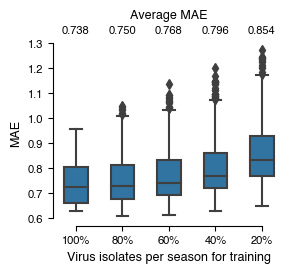

In [6]:
fig, ax = plt.subplots(figsize=(3,2.4))

plot = sns.boxplot(x='isolates_train', y='MAE', data=scores[scores.season!='Average'],
                   width=0.5,
                   color="C0",
                   ax=ax)

# annotate
# convert isolates_train from string with percent sign to float
scores['isolates_train'] = scores.isolates_train.str.rstrip('%').astype('int')
avg_MAE                  = scores[scores.season=='Average'].groupby(['isolates_train']).mean().MAE.sort_index(ascending=False)
for (xtick, label) in zip(plot.get_xticks(), avg_MAE):
    ax.text(xtick,
            1.34,
            f"{label:.3f}",
            horizontalalignment='center',
            fontsize=8,
            rotation=0)

ax.text(2, 1.40, "Average MAE", fontsize=9, horizontalalignment='center')


ax.set_xlabel('Virus isolates per season for training', fontsize=9)
ax.set_ylabel('MAE', fontsize=9)
ax.set_ylim(bottom=0.57, top=1.31)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')